In [10]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init

import matplotlib.pyplot as plt
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


**Model**

In [11]:
class MLP_CIFR10(nn.Module):
  # Batch norm = True enables the Batch-Normalization
  def __init__(self, input_size=3*32*32, h1_size = 500, h2_size = 250, h3_size = 100, num_classes = 10, batch_norm = False):
    super(MLP_CIFR10, self).__init__();
    self.batch_norm = batch_norm
    # Hidden Layer 1 with ReLU activation
    self.fc1 = nn.Linear(in_features = input_size, out_features = h1_size);
    if batch_norm == True:
      # print("Batch norm1 enabled")
      self.bn1 = nn.BatchNorm1d(h1_size)
    self.relu1 = nn.ReLU()
    # Hidden Layer 2 with ReLU activation
    self.fc2 = nn.Linear(in_features = h1_size, out_features = h2_size);
    if batch_norm == True:
      # print("Batch norm2 enabled")
      self.bn2 = nn.BatchNorm1d(h2_size)
    self.relu2 = nn.ReLU()
    # Hidden Layer 3 with ReLU activation
    self.fc3 = nn.Linear(in_features = h2_size, out_features = h3_size);
    if batch_norm == True:
      # print("Batch norm3 enabled")
      self.bn3 = nn.BatchNorm1d(h3_size)
    self.relu3 = nn.ReLU()
    # output layer
    self.fc_out = nn.Linear(in_features = h3_size, out_features = num_classes);
    self.softmax = nn.Softmax(dim = 1); # we need the output to be y0 to y9 depicitng the classes

  def forward(self, x):
    x = torch.flatten(x, 1); # flatten all dimensions except 1st dimension which represents batch size

    # Generate the output of Fully connected layer 1
    out = self.fc1(x);
    if self.batch_norm == True:
      out = self.bn1(out)
    out = self.relu1(out);

    # Generate the output of Fully connected layer 2
    out = self.fc2(out);
    if self.batch_norm == True:
      out = self.bn2(out)
    out = self.relu2(out);

    # Generate the output of Fully connected layer 3
    out = self.fc3(out);
    if self.batch_norm == True:
      out = self.bn3(out)
    out = self.relu3(out);

    # Final output layer
    out = self.fc_out(out);
    # softmax has not been applied here since the nn.CrossEntropyLoss() applies LogSoftmax on an input, followed by NLLLoss
    # Refernece for the above statemnet : https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss
    return out

**Initialize the model**

In [12]:
model = MLP_CIFR10(batch_norm=False).to(device) # Batch Normalization Turned off

**Creating Data Loader**

In [13]:
# Normalize input data to 0.5 mean and 0.5 SD

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

# load Training Dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

#Load Testing Dataset
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

# Different classes present in the data set
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


**Define Loss Function and Optimizer**

In [14]:
# Cross entropy loss
criterion = nn.CrossEntropyLoss()
# Stochastic Gradient Descent Optimiser, with learning rate = 0.001 and Momentum = 0.9
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

**Cross verify the Images with Labels**

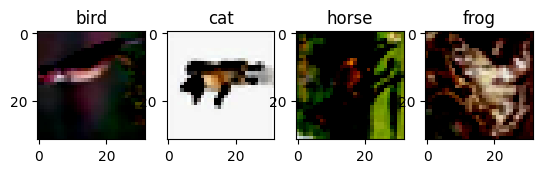

In [15]:

dataiter = iter(trainloader)

image, label = next(dataiter); #image size :  torch.Size([4, 3, 32, 32]), Batch size = 4

for i in range(batch_size):
  image_to_show = image.T[:,:,:,i] # number of channels, Height of image, width of image, batch size
  plt.subplot(1,batch_size, i+1)
  plt.imshow(image_to_show)
  plt.title(classes[label[i]])

**Train the Model**

[Epoch : 1, Step :  2000] , Average Training loss: 2.050745455235243
[Epoch : 1, Step :  4000] , Average Training loss: 1.757174305766821
[Epoch : 1, Step :  6000] , Average Training loss: 1.6824005272388458
[Epoch : 1, Step :  8000] , Average Training loss: 1.6173994615226983
[Epoch : 1, Step : 10000] , Average Training loss: 1.5964819515943527
[Epoch : 1, Step : 12000] , Average Training loss: 1.5565218421518803
[Epoch : 2, Step :  2000] , Average Training loss: 1.4580196150690317
[Epoch : 2, Step :  4000] , Average Training loss: 1.4640771860927344
[Epoch : 2, Step :  6000] , Average Training loss: 1.4413822045251727
[Epoch : 2, Step :  8000] , Average Training loss: 1.4612751085460185
[Epoch : 2, Step : 10000] , Average Training loss: 1.427089064463973
[Epoch : 2, Step : 12000] , Average Training loss: 1.3762313548624516
[Epoch : 3, Step :  2000] , Average Training loss: 1.3292630887776613
[Epoch : 3, Step :  4000] , Average Training loss: 1.3241856384351849
[Epoch : 3, Step :  600

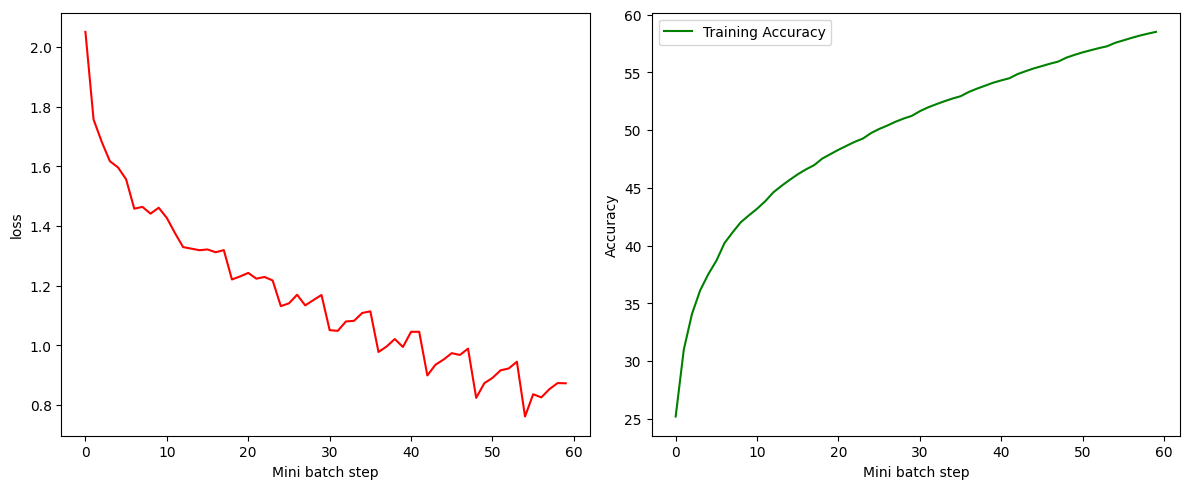


Training Finished with accuracy :  58


In [16]:
# start training the model
training_error = [] # TO caopture the training error
interm_training_acc = [] # to capture intermediate training accuracy
interm_total = 0
interm_correct = 0
total = 0     # Track the total images
correct = 0   # Track the number of matched labels for images

for epoch in range(10):

  running_loss = 0.0;

  for i, data in enumerate(trainloader):
    inputs, labels = data

    inputs = inputs.to(device)
    labels = labels.to(device)

    # reset the gradients to zero
    optimizer.zero_grad()

    # forward pass
    outputs = model(inputs)

     # Loss calculation with respect to Ground Truth labels
    loss = criterion(outputs, labels)

    # Back prop
    loss.backward()

    # Gradient update
    optimizer.step()

    # cumulative loss
    running_loss += loss.item()

    predicted_probability, predicted = torch.max(outputs.data, 1) # For each input image 10 probablities for classification will be predicted,
                                                                  # from that we need to pick the maximum probability class as our predicted class
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    interm_total, interm_correct = total, correct
    if ((i) % 2000) == 1999:    # print every 2000 mini-batches, each mini batch has 4 images
      avg_training_loss = running_loss / 2000;
      print(f'[Epoch : {epoch + 1}, Step : {i + 1:5d}] , Average Training loss: {avg_training_loss}')
      training_error.append(avg_training_loss)
      interm_training_acc.append((100*correct)/total)
      running_loss = 0.0

# Plot the metrics
fig = plt.figure(figsize=(12, 5))
fig.add_subplot(1,2,1)
plt.plot(training_error,color = 'r', label='Training Loss')
plt.xlabel('Mini batch step')
plt.ylabel('loss')

fig.add_subplot(1,2,2)
plt.plot(interm_training_acc,color = 'g', label='Training Accuracy')
plt.xlabel('Mini batch step')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

print("\nTraining Finished with accuracy : ", ((100 * correct)//total) )

**Accuracy for 10,000 images**

[Step :    50] , Average Validation loss: 0.15277633357048034
[Step :   100] , Average Validation loss: 0.1719592792391777
[Step :   150] , Average Validation loss: 0.13672817236185072
[Step :   200] , Average Validation loss: 0.15954202455282213
[Step :   250] , Average Validation loss: 0.12652308634668588
[Step :   300] , Average Validation loss: 0.13593868684768676
[Step :   350] , Average Validation loss: 0.14842946100234986
[Step :   400] , Average Validation loss: 0.14848214885592462
[Step :   450] , Average Validation loss: 0.1456097714006901
[Step :   500] , Average Validation loss: 0.14607786831259728
[Step :   550] , Average Validation loss: 0.1589417405128479
[Step :   600] , Average Validation loss: 0.15315185540914536
[Step :   650] , Average Validation loss: 0.16348702858388425
[Step :   700] , Average Validation loss: 0.1494603400528431
[Step :   750] , Average Validation loss: 0.14306334841251372
[Step :   800] , Average Validation loss: 0.16430219042301178
[Step :   85

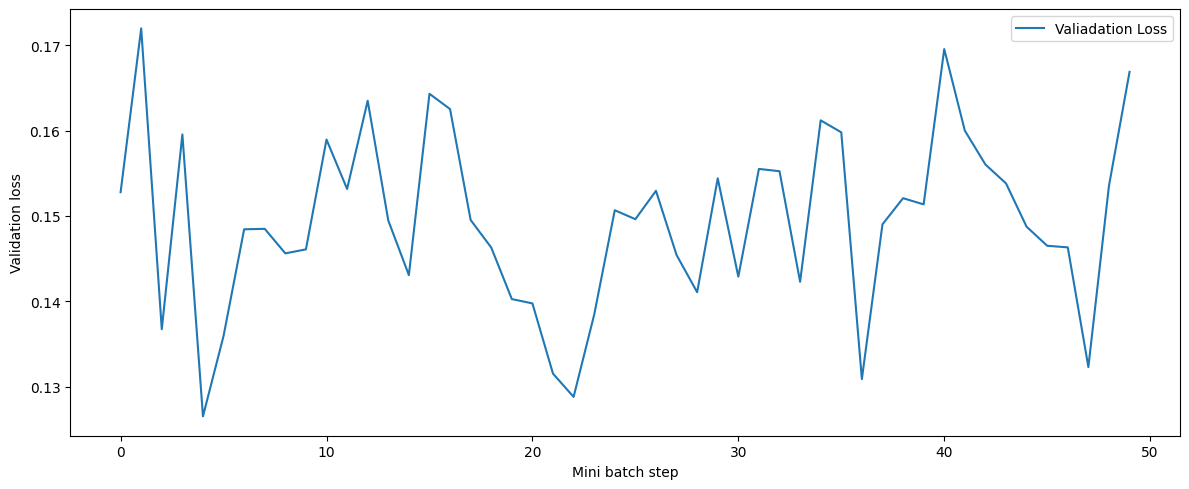


 Accuracy of the network on the 10000 test images: 53 %


In [17]:
correct = 0
total = 0
count = 0
validation_error = []
prediction_accuracy = []
validation_running_loss = 0.0
model.eval()
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for i, data in enumerate(testloader):
        count+=1
        images, labels = data # Batch sized images and labels will be loaded here i.e, 4 images and 4 labels are loaded
        images = images.to(device)
        labels = labels.to(device)

        # forward pass
        outputs = model(images)

        # loss computation
        loss = criterion(outputs, labels)

        # Accumulate the loss value
        validation_running_loss += loss.item()

        predicted_probability, predicted = torch.max(outputs.data, 1) # each input image will have 10 probablities for classification,
                                                                      # from that we need to pick the maximum probability class as our predicted class

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        if ((i+1) % 50) == 0:    # print every 500 mini-batches
          avg_validating_loss = validation_running_loss / 500;
          print(f'[Step : {i + 1:5d}] , Average Validation loss: {avg_validating_loss}')
          validation_error.append(avg_validating_loss)
          validation_running_loss = 0.0

# Plot
plt.figure(figsize=(12, 5))
plt.plot(validation_error, label='Valiadation Loss')
plt.xlabel('Mini batch step')
plt.ylabel('Validation loss')
plt.legend()

plt.tight_layout()
plt.show()

print(f'\n Accuracy of the network on the {count*batch_size} test images: {100 * correct // total} %')

**Saving the Model**

In [18]:
PATH = './cifar_net.pth'
torch.save(model.state_dict(), PATH)

**3.
Checking the Ground Truth Values for the Test data**

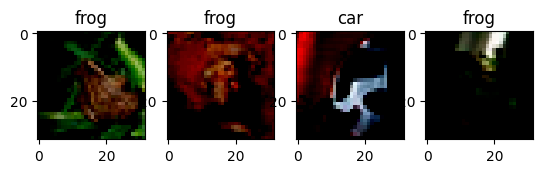

In [19]:
test_data_itr = iter(testloader)
test_images, labels = next(test_data_itr)
test_images, labels = next(test_data_itr)
# print the test images wiht it's ground truth value
for i in range(test_images.size(0)):
  image = test_images.T[:,:,:,i]
  plt.subplot(1, batch_size, i+1)
  plt.imshow(image)
  plt.title(classes[labels[i]])

**Load the Trained Model**

In [20]:
saved_model = MLP_CIFR10(batch_norm=False).to(device)
saved_model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [21]:
trained_outputs = saved_model(images)
predicted_probability, predicted = torch.max(trained_outputs, 1)

print("Predicted classes : ",  [classes[predicted[idx]] for idx in range(batch_size)])


Predicted classes :  ['dog', 'cat', 'frog', 'horse']


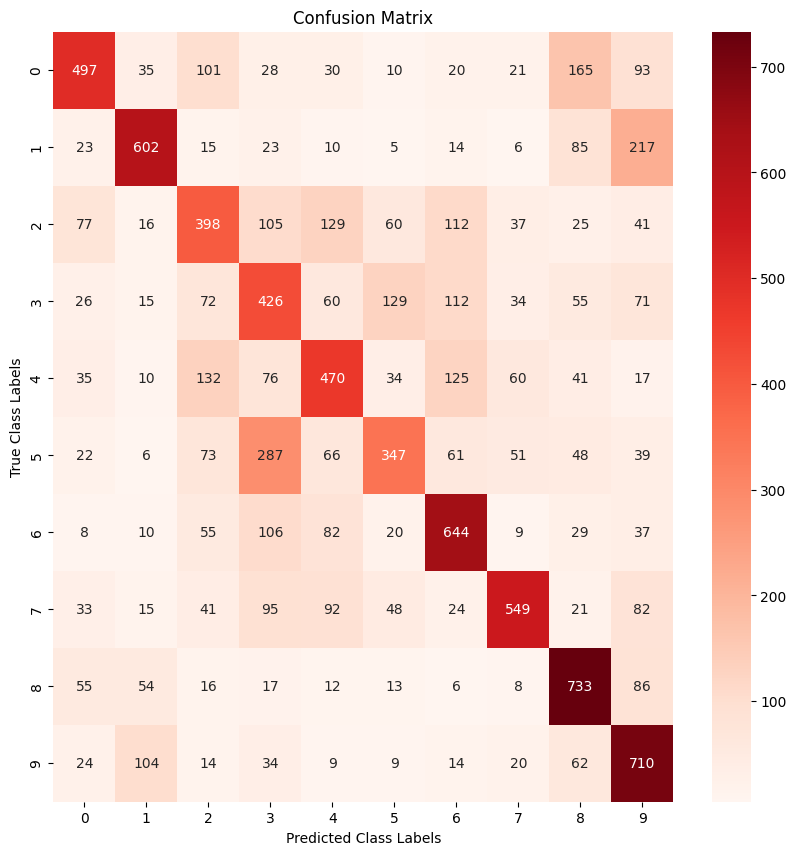

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

true_labels_list = []
predicted_labels_list   = []
model.eval()

with torch.no_grad( ):
  for images, labels in testloader:
    images = images.to(device)
    labels = labels.to(device)
    output = model(images)
    predictions = F.softmax(output, dim=1)
    predicted_values, predicted_labels = torch.max(predictions, 1)
    true_labels_list.extend(labels.cpu().numpy())
    predicted_labels_list.extend(predicted_labels.cpu().numpy())

disp_matrix = confusion_matrix(true_labels_list, predicted_labels_list)
# Plot the confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(disp_matrix, annot=True, fmt="d", cmap="Reds", xticklabels=range(10), yticklabels=range(10))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class Labels")
plt.ylabel("True Class Labels")
plt.show()
